In [1]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
from datetime import datetime
from datetime import timedelta
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    ExponentialSmoothing,
    ARIMA,
    RegressionEnsembleModel,
    RegressionModel
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

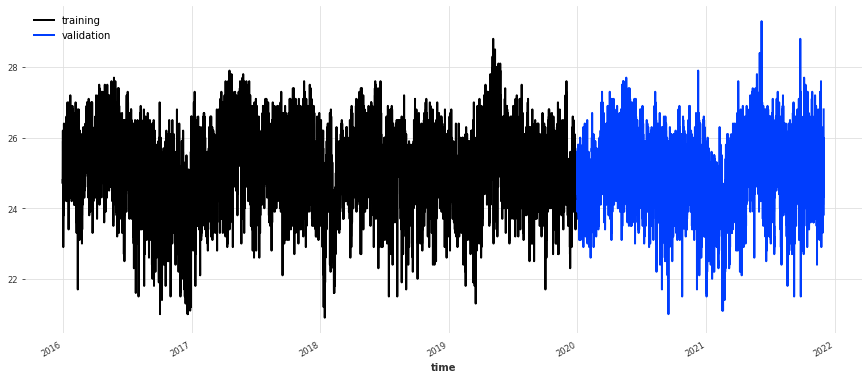

In [2]:
df = pd.read_csv("./data/wet-bulb-temperature-hourly.csv")
dt = [datetime.strptime(df.iloc[n,0], "%Y-%m-%d")+timedelta(hours=int(df.iloc[n,1])-1) for n in range(df.shape[0])]
df.index = dt
df.drop(["wbt_date","wbt_time"],axis=1,inplace=True)
series = TimeSeries.from_dataframe(df)
_, series = series.split_before(pd.Timestamp('20160101'))
train, val = series.split_before(pd.Timestamp('20200101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

## Ensembling several predictions

Ensembling is about combining the forecasts produced by several models, in order to obtain a final – and hopefully better forecast.

In [3]:
models = [NaiveSeasonal(12), NaiveSeasonal(24), NaiveDrift()]

model_predictions = [m.historical_forecasts(series,
                                            start=pd.Timestamp('20170101'),
                                            forecast_horizon=12,
                                            stride=12,
                                            last_points_only=False,
                                            verbose=True)
                     for m in models]

model_predictions = [reduce((lambda a, b: a.append(b)), model_pred) for model_pred in model_predictions]

  0%|          | 0/3590 [00:00<?, ?it/s]

  0%|          | 0/3590 [00:00<?, ?it/s]

  0%|          | 0/3590 [00:00<?, ?it/s]

In [4]:
model_predictions_stacked = model_predictions[0]
for model_prediction in model_predictions[1:]:
    model_predictions_stacked = model_predictions_stacked.stack(model_prediction)

In [ ]:
""" We build the regression model, and tell it to use the current predictions
"""
regr_model = RegressionModel(lags=None, lags_future_covariates=[0])

""" Our target series is what we want to predict (the actual data)
    It has to have the same time index as the features series:
"""
series_target = series.slice_intersect(model_predictions[0])

""" Here we backtest our regression model
"""
ensemble_pred = regr_model.historical_forecasts(
    series=series_target, future_covariates=model_predictions_stacked,
    start=pd.Timestamp('20180101'), forecast_horizon=12, stride=12, verbose=True
)

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.ravel()

for i, m in enumerate(models):
    series.plot(label='actual', ax=ax[i])
    model_predictions[i].plot(label=str(m), ax=ax[i])

    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)

    mape_model = mape(series, model_pred)
    ax[i].set_title('\nMAPE: {:.2f}%'.format(mape_model))
    ax[i].legend()

series.plot(label='actual', ax=ax[3])
ensemble_pred.plot(label='Ensemble', ax=ax[3])
ax[3].set_title('\nMAPE, ensemble: {:.2f}%'.format(mape(series, ensemble_pred)))
ax[3].legend()

print('\nRegression coefficients for the individual models:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[i]))
plt.tight_layout();

## RegressionEnsembleModel approach

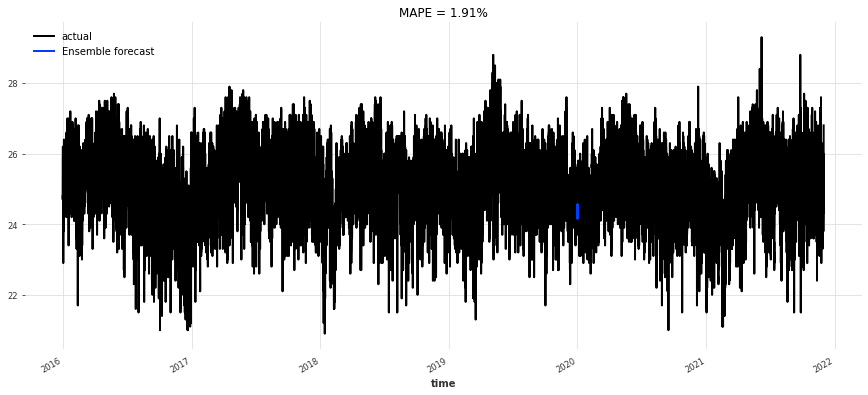

In [8]:
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(12), NaiveSeasonal(24), NaiveDrift()],
    regression_train_n_points=12)

ensemble_model.fit(train)
ensemble_pred = ensemble_model.predict(48)

series.plot(label='actual')
ensemble_pred.plot(label='Ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred, series)))
plt.legend();

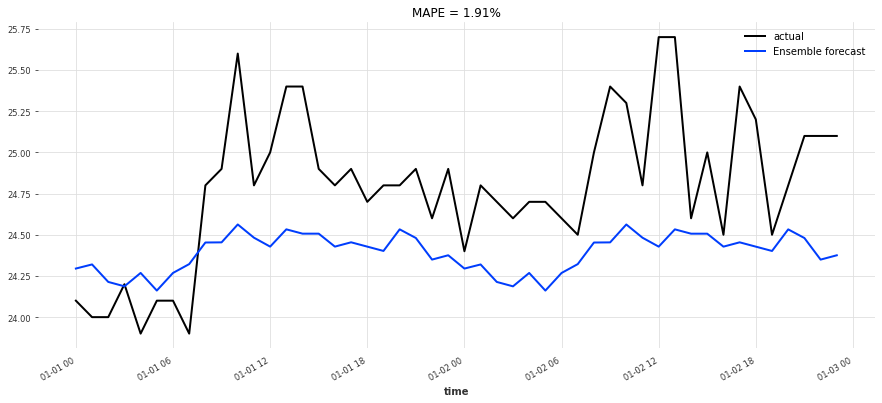

In [9]:
val[:48].plot(label='actual')
ensemble_pred.plot(label='Ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred, series)))
plt.legend();

### Only Naive model

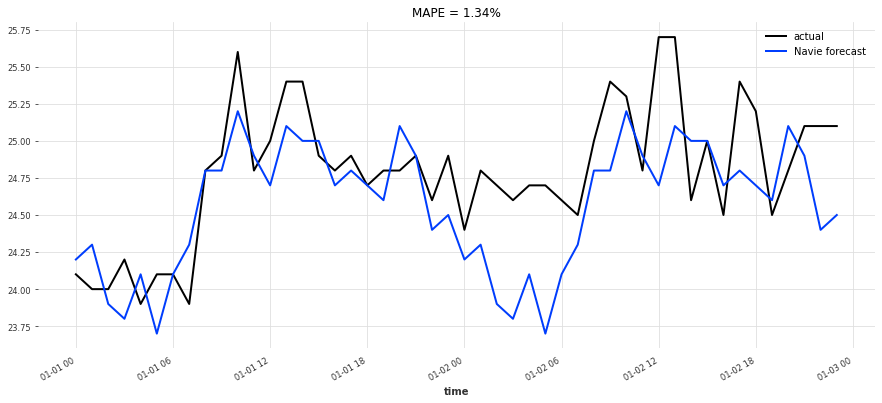

In [11]:
naive_model = NaiveSeasonal(K=24)
naive_model.fit(train)
naive_forecast = naive_model.predict(48)

val[:48].plot(label='actual')
naive_forecast.plot(label='Navie forecast')
plt.title('MAPE = {:.2f}%'.format(mape(naive_forecast, series)))
plt.legend();